This notebook is adapted from the original make_figs.ipynb file in the L-WISE codebase.

# Converting .h5 files to documents

In [ ]:
DEIDENTIFIED_DATA = True

!pip install xarray --quiet

In [ ]:
from google.colab import files
uploaded = files.upload()
h5_file = list(uploaded.keys())[0]
print("Loaded:", h5_file)

Saving maggie_experiment_3_full.h5 to maggie_experiment_3_full.h5
Loaded: maggie_experiment_3_full.h5


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
# copied from codespace's original make_figs notebook
def get_df_from_xarray(data_paths, drop_columns=None):
    start_pt_idx = 0
    dfs = []
    for data_path in data_paths:
        assert os.path.isfile(data_path), f"File {data_path} not found"
        ds = xr.open_dataset(data_path)
        raw = ds.to_dataframe().reset_index()
        # only keep rows where choice_slot==i_choice (or missing choice treated as slot 0)
        df = raw[(raw.choice_slot==raw.i_choice) |
                 (raw.i_choice.isna() & (raw.choice_slot==0))]
        df["participant"] = start_pt_idx + df["participant"]
        start_pt_idx += df["participant"].nunique()
        dfs.append(df)
    combined = pd.concat(dfs, ignore_index=True)
    if drop_columns:
        combined = combined.drop(drop_columns, axis=1, errors='ignore')
    combined = combined.sort_values(by=["participant","obs"])
    # reorder a few core columns
    cols = ["participant","condition_idx","block","obs",
            "trial_type","stimulus_name","choice_name",
            "perf","reaction_time_msec","rel_timestamp_response"]
    other = [c for c in combined.columns if c not in cols]
    return combined[cols+other]

def bootstrap_ci(data, n=10000, ci=0.95):
    boots = np.array([np.mean(np.random.choice(data, len(data), True))
                      for _ in range(n)])
    low, high = np.percentile(boots, [(1-ci)/2*100, (1+ci)/2*100])
    return low, high

def print_main_stats(df, cond_order, cond_labels,
                     chance=0.25, test_blocks=[8,9]):
    accs, cis = [], []
    for c in cond_order:
        sub = df[(df.condition_idx==c)&df.block.isin(test_blocks)]
        m = sub.perf.mean()
        ci = bootstrap_ci(sub.perf)
        accs.append(m); cis.append(ci)
    out = pd.DataFrame({
        "Condition": cond_labels,
        "Accuracy": accs,
        "CI_low": [c[0] for c in cis],
        "CI_high":[c[1] for c in cis]
    })
    out["yerr_low"] = out.Accuracy - out.CI_low
    out["yerr_high"]= out.CI_high - out.Accuracy
    display(out)
    # plus any %‐above-chance, etc...

In [ ]:
drop_cols = [
  "stimulus_image_urls","mask_image_url","query_string",
  "platform","bonus_usd_if_correct","choice_slot"
]
# if you need to de‐identify:
# drop_cols += ["worker_id","assignment_id"]

df1 = get_df_from_xarray([h5_file], drop_columns=drop_cols)
df1["experiment_id"] = "experiment_1"
df1.perf = df1.perf.fillna(0)

print("Participants:", df1.participant.nunique())
print("Trials:", len(df1))
df1.head(-5)

Participants: 9
Trials: 468


<ipython-input-33-80d5f6a502cd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["participant"] = start_pt_idx + df["participant"]


,participant,condition_idx,block,obs,trial_type,stimulus_name,choice_name,perf,reaction_time_msec,rel_timestamp_response,...,i_correct_choice,monitor_height_px,monitor_width_px,stimulus_width_px,timestamp_start,assignment_id,trialset_id,worker_id,bonus_usd,experiment_id
0,0,0,1,0,tongue_nat,Feet,Feet,1.0,5109.2,17160.0,...,1,1107,1710,514.500000,1.747092e+09,2bac5ebe-f9b4-4532-bf77-1441717f7001,4,UNKNOWN,0.0,experiment_1
9,0,0,1,1,tongue_nat,Tongue,Tongue,1.0,5503.4,23837.1,...,0,1107,1710,514.500000,1.747092e+09,2bac5ebe-f9b4-4532-bf77-1441717f7001,4,UNKNOWN,0.0,experiment_1
18,0,0,1,2,tongue_nat,Tongue,Tongue,1.0,1963.9,26999.3,...,0,1107,1710,514.500000,1.747092e+09,2bac5ebe-f9b4-4532-bf77-1441717f7001,4,UNKNOWN,0.0,experiment_1
27,0,0,1,3,tongue_nat,Feet,Tongue,0.0,1933.1,30100.0,...,1,1107,1710,514.500000,1.747092e+09,2bac5ebe-f9b4-4532-bf77-1441717f7001,4,UNKNOWN,0.0,experiment_1
36,0,0,1,4,tongue_nat,Tongue,Feet,0.0,3251.5,35585.1,...,0,1107,1710,514.500000,1.747092e+09,2bac5ebe-f9b4-4532-bf77-1441717f7001,4,UNKNOWN,0.0,experiment_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,8,0,1,42,tongue_nat,Tongue,Tongue,1.0,5860.2,258244.2,...,0,960,1536,450.522051,1.747084e+09,78c485df-cf5c-4060-bbc9-accc209255df,5,UNKNOWN,0.0,experiment_1
395,8,0,1,43,tongue_nat,Tongue,Feet,0.0,9431.6,269049.0,...,0,960,1536,450.522051,1.747084e+09,78c485df-cf5c-4060-bbc9-accc209255df,5,UNKNOWN,0.0,experiment_1
404,8,0,1,44,tongue_nat,Feet,Feet,1.0,6088.7,277723.8,...,1,960,1536,450.522051,1.747084e+09,78c485df-cf5c-4060-bbc9-accc209255df,5,UNKNOWN,0.0,experiment_1
413,8,0,1,45,tongue_nat,Tongue,Feet,0.0,2760.8,281645.1,...,0,960,1536,450.522051,1.747084e+09,78c485df-cf5c-4060-bbc9-accc209255df,5,UNKNOWN,0.0,experiment_1


In [ ]:
# convert to csv
df1.to_csv("maggie_experiment_3_fulldoc", index=False)

# Analyzing Participant Data: Accuracy and Reaction Time

In [47]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [48]:
df2 = pd.read_csv('experiment_2.csv')
df3 = pd.read_csv('experiment_3.csv')

In [111]:
# functions taken from original make_figs.ipynb

def add_trial_index(df):
    #df = df.sort_values(['participant', 'block', 'trial'])
    df = df.copy()
    df['trial_index'] = df.groupby('trialset_id').cumcount() + 1
    return df

def smooth_with_forced_start(x, window_length=31, polyorder=2, force_points=1):
    sm = savgol_filter(x, window_length, polyorder, mode='nearest')
    sm[:force_points] = x[:force_points]
    return sm

def smooth_performance(df):
    df = df.copy()
    df['smoothed_perf'] = (df.sort_values(['trialset_id','trial_index']).groupby('trialset_id')['perf'].transform(lambda x: smooth_with_forced_start(x.values)))
    df['smoothed_perf'] = df['smoothed_perf'].clip(0,1)
    return df

# new functions
def get_learning_curve(df, condition_idx):
    d = df[df['condition_idx']==condition_idx].copy()
    d = add_trial_index(d)
    d = smooth_performance(d)
    grouped = d.groupby('trial_index')['smoothed_perf']
    return grouped.mean(), grouped.sem()

def get_reaction_time_curve(df, condition_idx):
    d = df[df['condition_idx']==condition_idx]
    d = add_trial_index(d)
    g = d.groupby('trial_index')['reaction_time_msec']
    return g.mean(), g.sem()


## experiment_2 --> Left vs. Right Hand

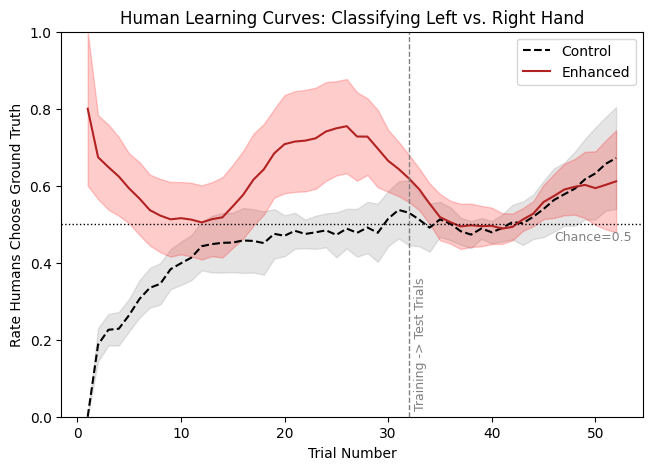

In [112]:
ctrl_mean, ctrl_sem = get_learning_curve(df2, 0)
enh_mean, enh_sem = get_learning_curve(df2, 1)

plt.figure(figsize=(7.5, 5))

# control - naturla/unenhanced, condition_idx=0 in df
plt.plot(ctrl_mean.index, ctrl_mean, color='black', linestyle='--', label='Control')
plt.fill_between(ctrl_mean.index, ctrl_mean-ctrl_sem, ctrl_mean+ctrl_sem, color='gray', alpha=0.2)

# enhanced - condition_idx=1 in df
plt.plot(enh_mean.index, enh_mean, color='firebrick', label='Enhanced')
plt.fill_between(enh_mean.index, enh_mean-enh_sem, enh_mean+enh_sem, color='red', alpha=0.2)


# add vertical line separating when enhanced images become unenhanced
plt.axvline(x=32, color='gray', linestyle='dashed', linewidth=1)
plt.text(32 + 0.5, 0.19, "Training -> Test Trials", rotation=90, va='center', ha='left', fontsize=9, color='gray')

# add horz line representing random chance
plt.axhline(y=0.5, color='black', linestyle='dotted', linewidth=1)
plt.text(46, 0.5-0.05, 'Chance=0.5', fontsize=9, color='gray', va='bottom')

plt.xlabel('Trial Number')
plt.ylabel('Rate Humans Choose Ground Truth')
plt.ylim(0,1)
plt.title('Human Learning Curves: Classifying Left vs. Right Hand')
plt.legend()
plt.show()

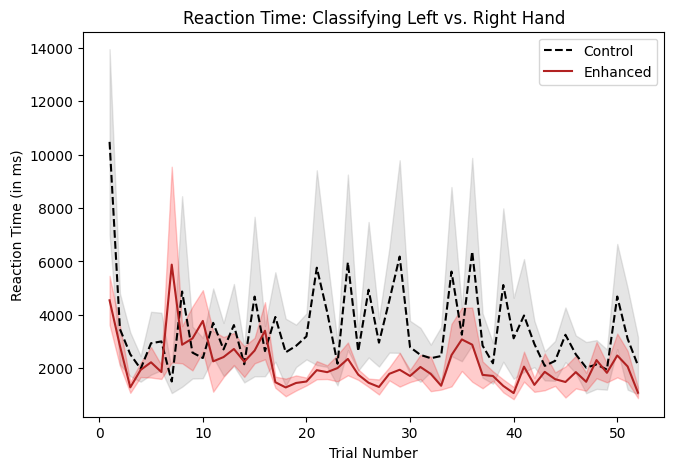

In [116]:
ctrl_rt, ctrl_sem = get_reaction_time_curve(df2, 0)
enh_rt, enh_sem = get_reaction_time_curve(df2, 1)

plt.figure(figsize=(7.5, 5))

plt.plot(ctrl_rt.index, ctrl_rt, color='black', linestyle='--', label='Control')
plt.fill_between(ctrl_rt.index, ctrl_rt-ctrl_sem, ctrl_rt+ctrl_sem, color='gray', alpha=0.2)

plt.plot(enh_rt.index, enh_rt, color='firebrick', label='Enhanced')
plt.fill_between(enh_rt.index, enh_rt-enh_sem, enh_rt+enh_sem, color='red', alpha=0.2)

plt.xlabel('Trial Number')
plt.ylabel('Reaction Time (in ms)')
plt.title('Reaction Time: Classifying Left vs. Right Hand')
plt.legend()
plt.show()

## experiment_3 --> Tongue vs. Feet

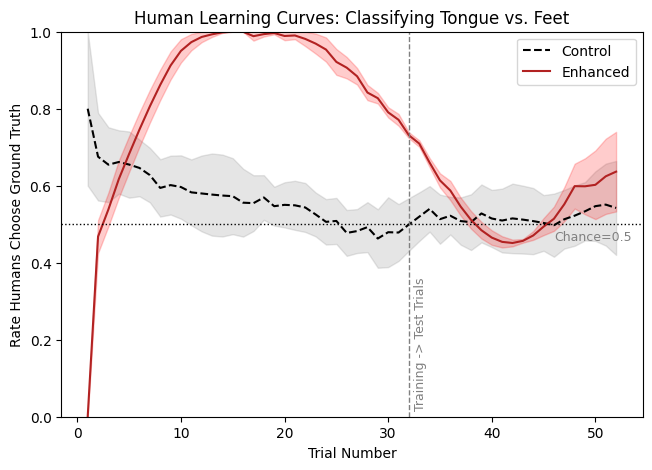

In [121]:
ctrl_mean, ctrl_sem = get_learning_curve(df3, 0)
enh_mean, enh_sem = get_learning_curve(df3, 1)

plt.figure(figsize=(7.5, 5))

# control - naturla/unenhanced, condition_idx=0 in df
plt.plot(ctrl_mean.index, ctrl_mean, color='black', linestyle='--', label='Control')
plt.fill_between(ctrl_mean.index, ctrl_mean-ctrl_sem, ctrl_mean+ctrl_sem, color='gray', alpha=0.2)

# enhanced - condition_idx=1 in df
plt.plot(enh_mean.index, enh_mean, color='firebrick', label='Enhanced')
plt.fill_between(enh_mean.index, enh_mean-enh_sem, enh_mean+enh_sem, color='red', alpha=0.2)


# add vertical line separating when enhanced images become unenhanced
plt.axvline(x=32, color='gray', linestyle='dashed', linewidth=1)
plt.text(32 + 0.5, 0.19, "Training -> Test Trials", rotation=90, va='center', ha='left', fontsize=9, color='gray')

# add horz line representing random chance
plt.axhline(y=0.5, color='black', linestyle='dotted', linewidth=1)
plt.text(46, 0.5-0.05, 'Chance=0.5', fontsize=9, color='gray', va='bottom')

plt.xlabel('Trial Number')
plt.ylabel('Rate Humans Choose Ground Truth')
plt.ylim(0,1)
plt.title('Human Learning Curves: Classifying Tongue vs. Feet')
plt.legend()
plt.show()

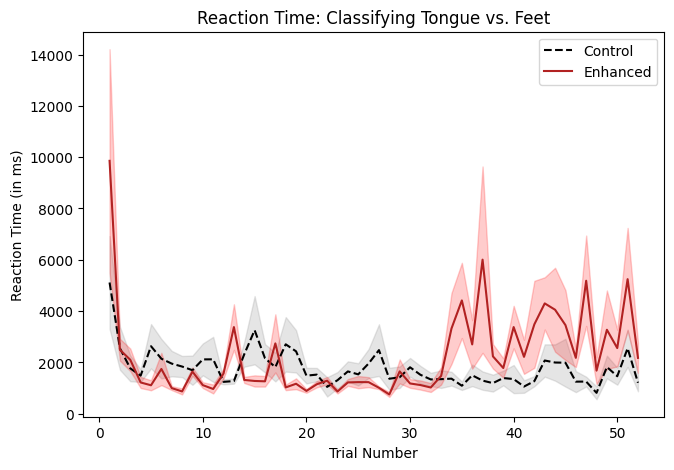

In [117]:
ctrl_rt, ctrl_sem = get_reaction_time_curve(df3, 0)
enh_rt, enh_sem = get_reaction_time_curve(df3, 1)

plt.figure(figsize=(7.5, 5))

plt.plot(ctrl_rt.index, ctrl_rt, color='black', linestyle='--', label='Control')
plt.fill_between(ctrl_rt.index, ctrl_rt-ctrl_sem, ctrl_rt+ctrl_sem, color='gray', alpha=0.2)

plt.plot(enh_rt.index, enh_rt, color='firebrick', label='Enhanced')
plt.fill_between(enh_rt.index, enh_rt-enh_sem, enh_rt+enh_sem, color='red', alpha=0.2)

plt.xlabel('Trial Number')
plt.ylabel('Reaction Time (in ms)')
plt.title('Reaction Time: Classifying Tongue vs. Feet')
plt.legend()
plt.show()